In [1]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML

PATH = '/content/drive/MyDrive/[202309]collect-JMA-forecast'

In [2]:
with open(PATH + '/areaCode.json', 'r') as f:
    areaCode_dict = json.load(f)

with open(PATH + '/weatherCode.json', 'r') as f:
    weatherCode_dict = json.load(f)

def get_weather_icon(weatherCode):
    img_url = f'https://www.jma.go.jp/bosai/forecast/img/{weatherCode_dict[str(weatherCode)][0]}'
    img = f'<img src="{img_url}">'
    return img

In [3]:
# データを取得
scope = ['https://spreadsheets.google.com/feeds','https://www.googleapis.com/auth/drive']
credentials = ServiceAccountCredentials.from_json_keyfile_name(PATH + '/api-key.json', scope)
gc = gspread.authorize(credentials)
st = gc.open_by_key('xxxxxxxxxxxxxxxxxxxxxx').sheet1
data = st.get_all_values()

df = pd.DataFrame(data[1:], columns=data[0])
df = df.replace('', np.nan)
df = df.astype({'pop':'float','tempMin':'float','tempMinUpper':'float','tempMinLower':'float','tempMax':'float','tempMaxUpper':'float','tempMaxLower':'float'})

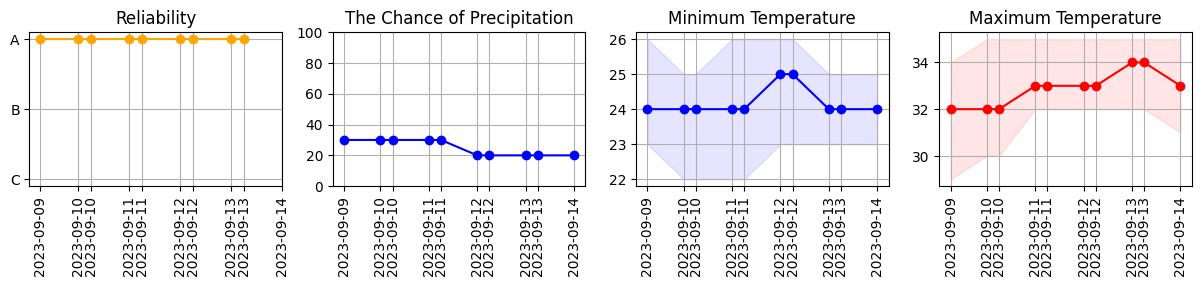

In [6]:
targetDate = '2023-09-16'
area = '滋賀県'

areaCode = areaCode_dict[area]
sub = df[df['targetDate']+df['areaCode'] == targetDate+'T00:00:00+09:00'+areaCode]

# 予報対象日時
display(HTML(f'<h2>{targetDate}の{area}の予報の変化</h2>'))

# 予報発表日時
date_html = ''
for date in sub['reportDatetime'].values:
    date_html += '<span style="font-size: 11px;">' + date[:10] + '(' + date[11:13] + '時)' + '\t→\t' + '</span>'
display(HTML(date_html))

# 天気アイコン
icon = ''
for weatherCode in sub['weatherCode'].values:
    if weatherCode is not np.nan:
        icon += get_weather_icon(weatherCode)
icon = '<style>.image-container {display: flex; gap: 37px;}</style><div class="image-container">' + icon + '</div>'
display(HTML(icon))


#　信頼度
plt.figure(figsize=(15,2))
plt.subplot(1,4,1)
plt.plot(pd.to_datetime(sub['reportDatetime']), sub['reliability'].map({'A':3,'B':2,'C':1}), color='orange', marker='o')
plt.xticks(pd.to_datetime(sub['reportDatetime']), rotation=90)
plt.yticks(ticks=[1,2,3], labels=['C','B','A'])
plt.ylim(0.9,3.1)
plt.title('Reliability')
plt.grid()

# 降水確率
plt.subplot(1,4,2)
plt.plot(pd.to_datetime(sub['reportDatetime']), sub['pop'], color='blue', marker='o')
plt.xticks(pd.to_datetime(sub['reportDatetime']), rotation=90)
plt.ylim(0,100)
plt.title('The Chance of Precipitation')
plt.grid()

# 最低気温
plt.subplot(1,4,3)
plt.plot(pd.to_datetime(sub['reportDatetime']), sub['tempMin'], color='blue', marker='o')
plt.fill_between(pd.to_datetime(sub['reportDatetime']), sub['tempMinLower'], sub['tempMinUpper'], alpha=0.1, color='blue')
plt.xticks(pd.to_datetime(sub['reportDatetime']), rotation=90)
plt.title('Minimum Temperature')
plt.grid()

# 最高気温
plt.subplot(1,4,4)
plt.plot(pd.to_datetime(sub['reportDatetime']), sub['tempMax'], color='red', marker='o')
plt.fill_between(pd.to_datetime(sub['reportDatetime']), sub['tempMaxLower'], sub['tempMaxUpper'], alpha=0.1, color='red')
plt.xticks(pd.to_datetime(sub['reportDatetime']), rotation=90)
plt.title('Maximum Temperature')
plt.grid()

plt.show()
